# ULMFiT + Siamese Network for Sentence Vectors
## Part One: Pretraining
This notebook will take a language model from lesson 10 of the Fast ai course on deeplearning and add a siamese network to create sentence vectors. We will be using the SNLI dataset. The first task will be to make a network that predicts entailment. Then we will create sentence vectors and determine suitability for use as a similarity metric.

### You must have the fastai library installed

In [18]:
from fastai.text import *
import html

import json
import html
import re
import pickle
from collections import Counter
import random
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn
from sklearn import model_selection
from functools import partial
from collections import Counter, defaultdict

import numpy as np
import torch
import torch.nn as nn
import torch.utils 
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import dataset, dataloader
import torch.optim as optim
import torch.nn.functional as F

import time
import math
import sys
import data

snli_root = './data/SNLI/'

## Load the tokens from the SNLI data

In [19]:
#load the results so we can pick it up from here 
itos = pickle.load(open(f'{snli_root}itos.pkl', 'rb'))
trn_lm = np.load(f'{snli_root}trn_lm.npy')
val_lm = np.load(f'{snli_root}val_lm.npy')

stoi = defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
vocab_size = len(itos)
vocab_size

8842

In [20]:
# check to make sure that the data looks ok
for word in trn_lm[:100]:
    print(itos[word], end=" ")

x_bos two men sit peacefully on a park bench . x_bos the face is happy . x_bos a musician playing a guitar while he has the microphone inside his mouth . x_bos a man is holding a pile of newspapers in a lobby , and a woman next to him has taken one of the newspapers and is smiling . x_bos a group of brown - haired teenagers doing laundry . x_bos the man is blond . x_bos a man wearing a santa hat holds up a photo to the class . x_bos two people are cold hiking with their 

## Load the Wikitext LM and fix the weights

In [12]:
#download the wikitext LM
# ! wget -nH -r -np -P ./data/aclImdb/ http://files.fast.ai/models/wt103/

In [21]:
#these are the values used for the original LM
em_sz,nh,nl = 400,1150,3
PATH = Path('./data/aclImdb')
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [22]:
#get the mean weight value for any new vocab
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

itos2 = pickle.load(Path(PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

#fill in the missing values from the old vocab
new_w = np.zeros((vocab_size, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m
    
#fix up the wgts with the new values
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [23]:
max_seq = 20*70
wd = 1e-7
bptt = 70
batch_size = 32
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

trn_dl = LanguageModelLoader(trn_lm, batch_size, bptt)
val_dl = LanguageModelLoader(val_lm, batch_size, bptt)
md = LanguageModelData(PATH, 1, vocab_size, trn_dl, val_dl, bs=batch_size, bptt=bptt)

### Create the language model and load the weigths

In [28]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
learner = md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

learner.model.load_state_dict(wgts)

In [29]:
lr=1e-3
lrs = lr
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      4.572631   4.338611   0.278831  


[array([4.33861]), 0.2788308504081908]

In [30]:
learner.save('snli_language_model')

In [31]:
learner.load('snli_language_model')
learner.unfreeze()

In [32]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy   
    0      3.274126   3.068766   0.406044  


Exception ignored in: <bound method FilterDescriptor.__del__ of <torch.backends.cudnn.FilterDescriptor object at 0x7f6e36e09588>>
Traceback (most recent call last):
  File "/home/brian/.conda/envs/fastai/lib/python3.6/site-packages/torch/backends/cudnn/__init__.py", line 183, in __del__
    check_error(lib.cudnnDestroyFilterDescriptor(self._as_parameter_))
AttributeError: 'FilterDescriptor' object has no attribute '_as_parameter_'


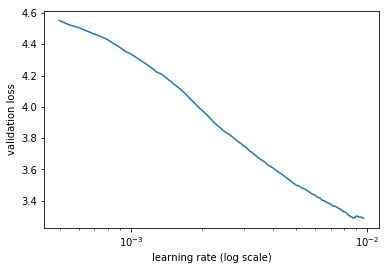

In [33]:
learner.sched.plot()

In [34]:
lrs=1e-2
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy   
    0      3.22766    3.059221   0.402561  
    1      2.950272   2.861857   0.429368  
    2      2.684402   2.664592   0.454843  
    3      2.483458   2.537937   0.47057   
    4      2.284647   2.373616   0.508327  
    5      2.128478   2.27421    0.528427  
    6      1.998572   2.159384   0.553845  
    7      1.874527   2.079468   0.5786    
    8      1.766519   2.012209   0.598665  
    9      1.656693   1.9454     0.618288  
    10     1.547815   1.894289   0.633645  
    11     1.485847   1.880976   0.640639  
    12     1.419843   1.841688   0.65214   
    13     1.332859   1.818702   0.658829  
    14     1.292993   1.818293   0.660853  


[array([1.81829]), 0.6608534767514184]

In [38]:
torch.save(learner.model[0], "SNLI_Encoder.pt")